In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from pyflann import *
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, auc
import cv2
import csv
import re
from sklearn.ensemble import RandomForestClassifier
import json
from tqdm import tqdm_notebook
import seaborn as sns

# %matplotlib notebook

coordinate_header = ['FrameNumber', 'MouthHook_x', 'MouthHook_y', 'LeftMHhook_x', 'LeftMHhook_y',
                     'RightMHhook_x', 'RightMHhook_y', 'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y',
                     'RightDorsalOrgan_x', 'RightDorsalOrgan_y', 'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y',
                     'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y', 'RightBolwigOrgan_x', 'RightBolwigOrgan_y']

distance_header = ['MouthHook', 'LeftMHhook',
                   'RightMHhook', 'LeftDorsalOrgan', 'RightDorsalOrgan',
                   'CenterBolwigOrgan', 'LeftBolwigOrgan', 'RightBolwigOrgan']

project_dir="G:/My Drive/CRG_Dropbox/AljoComputer/Temp"
dir_keypoints="../expts/KeypointsAndDescriptors/validKeyPoints"
dir_descriptors="../expts/KeypointsAndDescriptors/descriptors"

surf = cv2.xfeatures2d.SURF_create(hessianThreshold=400, nOctaves=3,nOctaveLayers=2, extended=True)

C:\Users\Shaul\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
# meta_data_header = ['FrameNumber', 'Stage_X', 'Stage_Y', 'X', 'Y', 'Head_X', 'Head_Y', 'Tail_X', 'Tail_Y']
super_root = "G:/My Drive/CRG_Dropbox/Tracker Development (Ajinkya)/MHDO_Tracking/data/Janelia_Q2_2015/20150501_MPEG4_EthylButyrate/Videos/relevant/"
# exp_list = ["002_20150501_142038_StageData_ContourData", "003_20150501_143057_StageData_ContourData",
#             "008_20150501_151739_StageData_ContourData", "009_20150501_152447_StageData_ContourData",
#             "012_20150501_155154_StageData_ContourData"]

exp_list = ["008_20150501_151739_StageData_ContourData"]

crop_size = 512
for exp in tqdm_notebook(exp_list):
    root = super_root + exp
    for fs in os.listdir(root):
        if '_pred.csv' in fs:
            meta_data_file = os.path.join(root, fs)
            meta_data = pd.read_csv(meta_data_file, sep=',')

In [8]:
meta_data_file

'G:/My Drive/CRG_Dropbox/Tracker Development (Ajinkya)/MHDO_Tracking/data/Janelia_Q2_2015/20150501_MPEG4_EthylButyrate/Videos/relevant/008_20150501_151739_StageData_ContourData\\Metadata_20150501_151739_pred.csv'

In [9]:
meta_data_sel = meta_data.loc[0:30000, :].copy()
s = meta_data_sel.loc[:, 'pred_probab'] > 0.2
meta_data_sel.loc[:, 'prediction'] = 0
meta_data_sel.loc[s, 'prediction'] = 1

In [13]:
len(s)

9765

In [10]:
meta_data_sel['pred_probab'].isnull().count()

9765

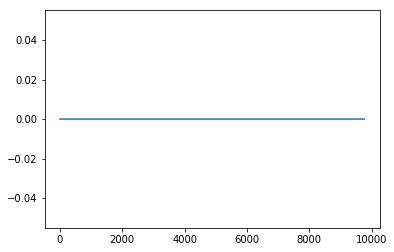

In [11]:
plt.plot(meta_data_sel.loc[:, 'prediction'])

In [ ]:
s = []
start = []
end = []
dif = []
st_end = []
s = meta_data_sel['prediction']
start = np.where(s.diff() == 1)[0]
end = np.where(s.diff() == -1)[0] - 1
dif =  np.r_[0, start[1:] - end[:-1]]
st_end = np.c_[start.T, end.T, dif.T]
# np.where(st_end[:, 2] < 2)
# st_end = np.delete(st_end, np.where(st_end[:, 2] < 2), 0)

st_end[:10, :]

In [ ]:
print st_end
to_combine = np.where(st_end[:, 2] <= 10)[0]
for i in to_combine:
    if i == 0:
        continue
    st_end[i-1, 1] = st_end[i, 1].copy()
    
print st_end
# st_end_2 = np.delete(st_end, to_combine, axis=0)
# st_end_2

In [ ]:
plt.hist(dif, bins=np.arange(0, 15))

In [ ]:
dsaf

In [ ]:
super_root = 'G:/My Drive/CRG_Dropbox\Tracker Development (Ajinkya)/MHDO_Tracking/data/Janelia_Q2_2015/20150501_MPEG4_NoOdor/Annotations_And_Frames'
all_annotations = []
for root, dirs, files in os.walk(super_root):
    if not dirs:
        for f in files:
            if os.path.splitext(f)[1] == ".json":
                with open(os.path.join(root, f)) as fin_annotation:
                    annotation = json.load(fin_annotation)
                    all_annotations.extend(annotation["Annotations"])

print "len(all_annotations):", len(all_annotations)

In [ ]:
meta_data_header = ['FrameNumber', 'Stage_X', 'Stage_Y', 'X', 'Y', 'Head_X', 'Head_Y', 'Tail_X', 'Tail_Y']
super_root = "G:/My Drive/CRG_Dropbox/Tracker Development (Ajinkya)/MHDO_Tracking/data/Janelia_Q2_2015/20150501_MPEG4_NoOdor/Videos/relevant/"
exp_list = ["005_20150430_174405_StageData_ContourData", "006_20150430_175243_StageData_ContourData",
            "009_20150430_182411_StageData_ContourData", "011_20150430_183916_StageData_ContourData",
            "015_20150430_191255_StageData_ContourData"]

crop_size = 512
for exp in tqdm_notebook(exp_list):
    root = super_root + exp    
    for fs in os.listdir(root):
        if '_pred.csv' in fs:
            meta_data_file = os.path.join(root, fs)
            meta_data = pd.read_csv(meta_data_file, sep=',')

In [ ]:
das

In [ ]:
plt.plot(meta_data_sel.loc[:, 'prediction'])

In [ ]:
meta_data